Autor: Bruno Augusto Souza Oliveira

Contatos: 
1. bruno.augusto.souza@outlook.com

2. https://www.linkedin.com/in/brunoaugustosouza/

3. (11)95471-3578

In [3]:
import numpy as np
from numpy import log as ln
import pandas as pd
import MetaTrader5 as mt5
from datetime import datetime as dt
import matplotlib.pyplot as plt

from scipy.stats import norm as N

O conteúdo apresentado aqui não se trata de recomendação, e sim possui apenas caráter didático, qualquer indicação e/ou aconselhamento de investimento é única e exclusiva responsabilidade do investidor a tomada de decisão. Eu, Bruno Augusto Souza Oliveira, não tenho qualquer responsabilidade, direta ou indireta, por todos e quaisquer prejuízos decorrentes de operações realizadas com base nas informações que serão apresentadas. Os produtos financeiros aqui relacionados não são geridos ou administrados por mim. Em suma, se você perder dinheiro usando o que estou ensinando aqui, problema é teu :)

# Introdução

Ja dizia o velho ditado, “Cut Your Losses and Let Your Profits Run”. Aqui estamos interessados em cortar nossas perdas através de um Stop Loss baseando-se no quantil de um movimento Browniano geométrico. Resumidamente, selecionaremos os piores caminhos que o nosso sistema pode tomar e utilizaremos isto como base para o Stop Loss, o cálculo será feito através do quantil calculado.

# Construção

Um processo estocástico $\{S_t\}_{t \geq 0}$ pode ser modelado como um mBg (movimento Browniano geométrico) se satisfazer a  SDE:

$$dS_t = \mu S_t dt + \sigma S_t dB_t$$

Neste caso, a solução da SDE acima é dada por $S_t = S_0 e^{X(t)}$, onde $X(t) = \left(\mu - \frac{\sigma^2}{2} \right)t + \sigma B_t$ e $B_t$ é um movimento Browniano, ou seja, $X(t)$ é um movimento Browniano com drift $\left(\mu - \frac{\sigma^2}{2}\right)$.

## Propriedades

$\quad$ i. $\lim_{t \to +\infty} \mathbb{P}\left(S_t = 0 \mid \mu - \frac{\sigma^2}{2} < 0\right) = 1$

[Demo] Dado que $\mu - \frac{\sigma^2}{2} < 0$ podemos concluir diretamente o resultado: 
$$\lim_{t \to +\infty} = S_0 e^{\left(\mu - \frac{\sigma^2}{2} \right)t + \sigma B_t} = 0$$

$\quad$ ii. $\lim_{t \to +\infty} \mathbb{P}\left(S_t = +\infty \mid \mu - \frac{\sigma^2}{2} > 0\right) = 1$. (Demonstração idêntica ao da propriedade i.)

iii. caso $\mu = \frac{\sigma^2}{2}$ temos que o limite $\lim_{t \to +\infty} = S_0 e^{\left(\mu - \frac{\sigma^2}{2} \right)t + \sigma B_t}$ é indefinido pois $\sigma B_t \sim \mathcal{N}(0, \sigma^2 t)$.

CUIDADOS - Talvez seja interessante analisar a velocidade de convergência de (i) e (ii). Suponha que você irá abrir uma posição de long em um ativo, seria interessante escolher aquele que diverge o mais rápido possível para infinito.


## Distribuição Lognormal

Diremos que $\frac{S_t}{S_0}$ distribui lognormal se $ln \frac{S_t}{S_0} \sim N(\mu, \sigma^2)$. Neste caso, seu quantil é definido como: 

$$q(p) = exp(\mu + \sigma \phi^{-1}(p)) \quad p \in (0, 1)$$

Perceba que $\mu + \sigma \phi^{-1}(p)$ é a quantil de uma normal, isto acontece pois os quantis tem a propriedade de serem preservados sob transformações monotônicas. Vale notar que $\phi^{-1}(p)$ é a inversa da CDF (Cumulative Distribution Function) de uma <b>Normal padrão<b> i.e. de $\mathcal{N}(0,1)$.
    
Pela solução de uma mBg, sabemos que:
    
$$ln \frac{S_t}{S_0} = X(t) = \left(\mu - \frac{\sigma^2}{2} \right)t + \sigma B_t \sim \mathcal{N}\left( \left[\mu - \frac{\sigma^2}{2}\right]t, \sigma^2 t \right)$$
    
Como $ln \frac{S_t}{S_0}$ distribui lognormal, temos que seu quantil é definido como:
    $$q(p) =  exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma\sqrt{t} \phi^{-1}(p)\right) \quad p \in (0,1)$$

# Programação

In [4]:
class gBm():
    """
        Geometric Brownian Motion model.
                dS_t = μ S_t dt + σ S_t dB_t
        
        Crescimento Exponencial. 
        o modelo tem um fit melhor para growth stocks como AAPL, TSLA, MGLU3, PRIO3 etc i.e.
        para ativos que tem um Crescimento Exponencial
    """
    
    def __init__(self, S):
        self.S = S
        self.estimateParams()
    
    def estimateParams(self):
        """
        Referência:
        "Estimation of Geometric Brownian Motion Parameters for Oil Price Analysis" C. Jakob et al.
        """
        S = self.S
        X = np.diff(np.log(S), n=1)
        m = X.mean() #mean
        σ = X.std() #standard deviation
        μ = m + ((σ**2)/2) #drift
        n = len(S)

        self.m = m
        self.σ = σ
        self.μ = μ
        self.n = n
    
    def E(self, t):
        """
        Referência:
        Ross, Sheldon M. (2014). "Variations on Brownian Motion".
        Introduction to Probability Models (11th ed.).
        """
        S = self.S
        S0 = S[0]
        μ = self.μ
        return S0*np.exp(μ*t)
    
    def Var(self, t):
        """
        Referência:
        Ross, Sheldon M. (2014). "Variations on Brownian Motion". 
        Introduction to Probability Models (11th ed.).
        """
        S = self.S
        S0 = S[0]
        μ = self.μ
        σ = self.σ
        return (S0**2)*np.exp(2*μ*t)*(np.exp((σ**2)*t) - 1)
    
    def q(self, p, t):
        """
         quantil de St/S0 o qual é definido como:
                q(p) = exp( (μ - σ**2/2)*t + σ*np.sqrt(t)*inv_Φ(p))
         p ∈ (0,1)
        """
        #assert p>0 and p<1
        #assert type(t)==int

        σ = self.σ
        μ = self.μ
        
        mean = (μ - (σ**2/2))*t
        var = σ**2*t
        return np.exp(mean +  np.sqrt(var)*N.ppf(p, 0, 1))

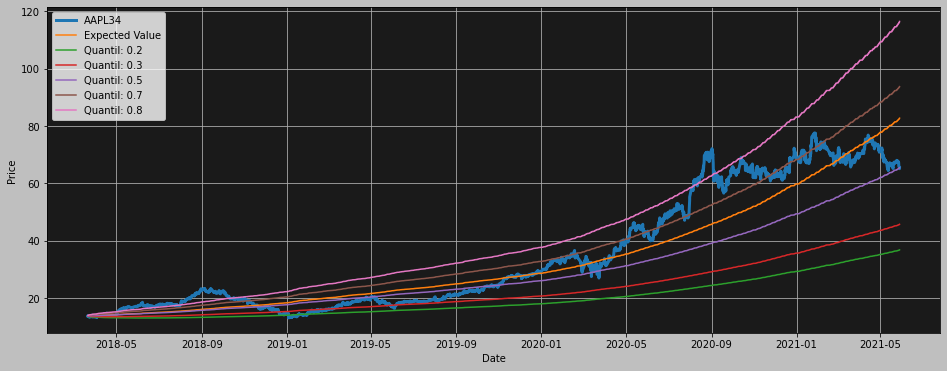

In [5]:
#Aqui vamos fazer um fit do modelo gBm para a BDR da Apple
ticker = 'AAPL34'
S = getTicksMt5(ticker, (2**12+1), mt5.TIMEFRAME_H1)
S = S[['close']]
X = gBm(S['close'].values)

fig, ax = plt.subplots(figsize=(16,6), facecolor=(0.75, 0.75, 0.75))


ax.plot(S['close'], label=ticker, linewidth=3.0)


S['Expected Value'] = X.E(np.arange(len(S)))
for q in [0.2, 0.3, 0.5, 0.7, 0.8]:
    S['Quantil: {}'.format(q)] = np.concatenate([np.array([None]),S['close'].iloc[0]*X.q(q, np.arange(1, len(S)))])
S.drop(['close'], axis=1, inplace=True)
for col in S.columns:
    ax.plot(S[col], label=col)

ax.set_facecolor((0.1, 0.1, 0.1))

ax.set_ylabel('Price')
ax.set_xlabel('Date')
    
ax.legend()
ax.grid()

### Limitações do modelo:

* É preciso que $ln \frac{S_t}{S_0} \sim \mathcal{N}(\mu, \sigma^2)$, ou seja, faz-se necessário um teste de normalidade no logaritmo dos retornos do ativo em questão.

* É preciso uma quantidade grande de dados para estimar os parâmetros, de forma que obtenha-se um bom intervalo de confiança. Aqui utilizamos o método 2 do artigo "Estimation of Geometric Brownian Motion Parameters for Oil Price Analysis" C. Jakob et al. com dados de HORA EM HORA e cerca de ~4000 para conduzir bons intervalos de confiança.

### Stop loss e take profit

Supondo que o processo continue seu comportamento para os paramêtros $\mu$ e $\sigma$ estimados, faremos com que a solução inicial para a SDE apresentada i.e. $S_0$ seja igual a $S_T$ onde $T$ é o tempo do último preço disponível. Portanto, ao fazer isto estamos supondo que o comportamento do sistema (Parâmetros) se permanecerá inalterado, em outras palavras, dados do passado refletem dados do futuro (O que sabemos muito bem que nem sempre é verdade). Podemos a partir disto criar um stop loss e um take profit baseado no quantil.  Por exemplo, $q(0.2)$ representaria os 20% piores cenários que um processo estocástico $S_t$ poderia tomar dado os parâmetros $\mu$ e $\sigma$.

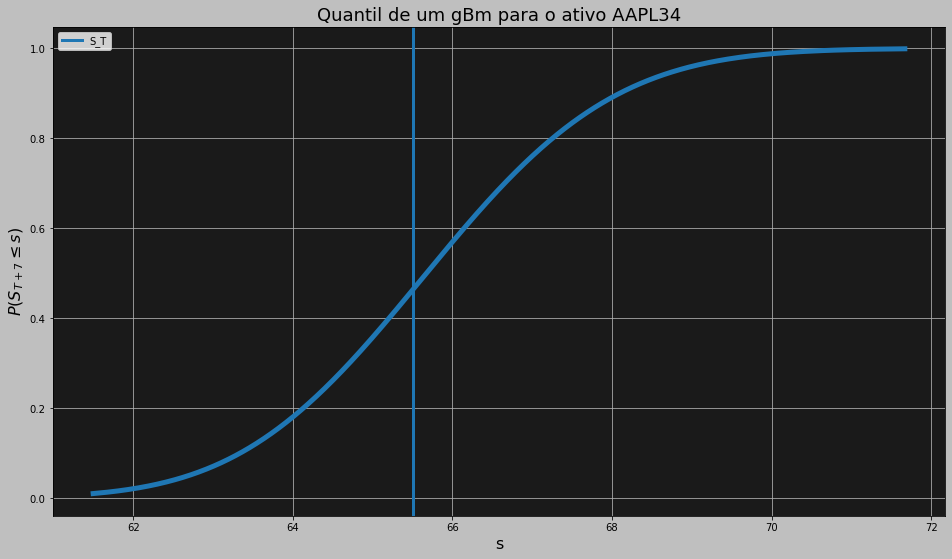

In [6]:
S = getTicksMt5(ticker, (2**12+1), mt5.TIMEFRAME_H1)
fig, ax = plt.subplots(figsize=(16,9), facecolor=(0.75, 0.75, 0.75))
S = getTicksMt5(ticker, (2**12+1), mt5.TIMEFRAME_H1)
t = np.linspace(0.01, 1, 1000, endpoint=False)

#Como estimamos o tempo em horas, vou utilizar uma previsão de +7 tempos para frente,
#visto que um pregão dura 7h e queremos estimar um stop loss para o fechamento do dia
ax.plot(S['close'].iloc[-1]*X.q(t, 7), t, '-', linewidth=5.0) 
ax.axvline(S['close'].iloc[-1], label='S_T', linewidth=3.0)
ax.set_xlabel('s', fontsize=16)
ax.set_ylabel('$P(S_{T+7} \leq s)$', fontsize=16)
ax.set_title('Quantil de um gBm para o ativo '+ticker, fontsize=18)
ax.legend()
ax.set_facecolor((0.1, 0.1, 0.1))
ax.grid()

In [16]:
p = 0.1
t = 7
sl = S['close'].iloc[-1]*X.q(p, t)
print('Para o ativo '+ticker+', cujo preço no dia {} terminou a '.format(S.iloc[-1].name)+ \
      str(S['close'].iloc[-1])+' (não me culpe por estar errado, o MetaTrader que me deu esse preço...)'+ \
     ' o Stop Loss para um quantil de {}'.format(p)+', olhando para o horizonte de 1 DIA (ou 7h) '+ \
     'é de: {:.2f}'.format(sl))

Para o ativo AAPL34, cujo preço no dia 2021-05-28 17:00:00 terminou a 65.5 (não me culpe por estar errado, o MetaTrader que me deu esse preço...) o Stop Loss para um quantil de 0.1, olhando para o horizonte de 1 DIA (ou 7h) é de: 63.34
